In [22]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

%matplotlib inline

from target import build_tgt_matrix
from imports import *
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
import scipy.stats
np.set_printoptions(suppress=True)

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [24]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/PSTH'

In [25]:
selected_sessions = [
# frequency
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events: FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events: very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, FIXME very weird 1-2nd in target, find out
    
# duration
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration - showcase for N2 
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, duration

# COMA
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, COMA session with baseline AEPs

# Old PPC sessions
'008229_hippoSIT_2022-05-17_21-44-43',  # chs: 0, 31, 54, 56
'008229_hippoSIT_2022-05-16_20-36-44',  # chs: 0, 56
'008229_hippoSIT_2022-05-20_15-54-39',  # chs: 0, 56
'008229_hippoSIT_2022-05-18_14-36-18',  # chs: 0, 56
]

session = selected_sessions[6]
area = 'PPC'

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5name      = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, session)
if not os.path.exists(report_path):
    os.makedirs(report_path)

In [26]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
with h5py.File(aeps_file, 'r') as f:
    #aeps = np.array(f['aeps_%s' % channel])
    aeps = np.array(f[area]['aeps'])
    aeps_events = np.array(f['aeps_events'])
    
# TODO find better way. Remove outliers
aeps[aeps > 5000]  = 5000
aeps[aeps < -5000] = -5000

# # load metrics
AEP_metrics_lims = {}
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_file, 'r') as f:
    for metric_name in f[area]['raw']:
        AEP_metrics_raw[metric_name]  = np.array(f[area]['raw'][metric_name])
        AEP_metrics_norm[metric_name] = np.array(f[area]['norm'][metric_name])
        AEP_metrics_lims[metric_name] = [int(x) for x in f[area]['raw'][metric_name].attrs['limits'].split(',')]

tgt_dur = cfg['experiment']['target_duration']
tgt_matrix = build_tgt_matrix(tl, aeps_events, tgt_dur)

aeps.shape, tgt_matrix.shape

((5989, 200), (43, 5))

## Metric distributions

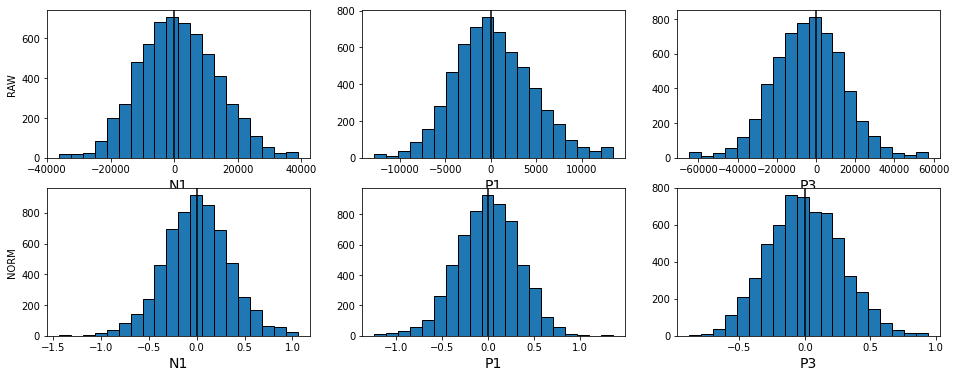

In [27]:
fig, axes = plt.subplots(2, len(AEP_metrics_lims), figsize=(16, 6))

titles = ['RAW', 'NORM']
for j, metrics in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for i, (name, data) in enumerate(metrics.items()):
        axes[j, i].hist(data, bins=20, edgecolor='black')
        axes[j, i].set_xlabel(name, fontsize=14)
        axes[j, i].axvline(0, color='black')
        
        if i == 0:
            axes[j, i].set_ylabel(titles[j])

## Correlation matrix

In [28]:
# metrics / units
dim = len(AEP_metrics_norm)
corr_pearson_raw  = np.zeros((dim, dim))  # N1, P1, N2, etc.
corr_pearson_norm = np.zeros((dim, dim))  # N1, P1, N2, etc.
metric_names = list(AEP_metrics_norm.keys())
for i, metric1 in enumerate(metric_names):
    for j, metric2 in enumerate(metric_names):
        m1 = AEP_metrics_raw[metric1]
        m2 = AEP_metrics_raw[metric2]
        m3 = AEP_metrics_norm[metric1]
        m4 = AEP_metrics_norm[metric2]

        corr_pearson_raw[i, j]   = pearsonr(m1, m2)[0]
        corr_pearson_norm[i, j]  = pearsonr(m3, m4)[0]

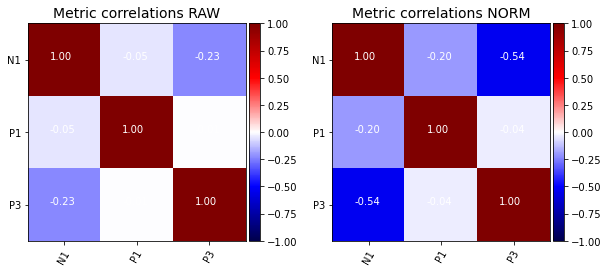

In [29]:
fig = plt.figure(figsize=(10, 4))

titles = ['RAW', 'NORM']
for i, corr_pearson in enumerate([corr_pearson_raw, corr_pearson_norm]):
    ax = fig.add_subplot(1, 2, i+1)
    im = ax.imshow(corr_pearson, cmap='seismic', vmin=-1)
    ax.set_xticks(range(corr_pearson.shape[1]))
    ax.set_xticklabels(metric_names, rotation=60)
    ax.set_yticks(range(corr_pearson.shape[0]))
    _ = ax.set_yticklabels(metric_names)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Metric correlations %s' % titles[i], fontsize=14)
    for p in range(corr_pearson.shape[0]):
        for q in range(corr_pearson.shape[1]):
            ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')

## N1, P1, N2 stats inside / outside the island

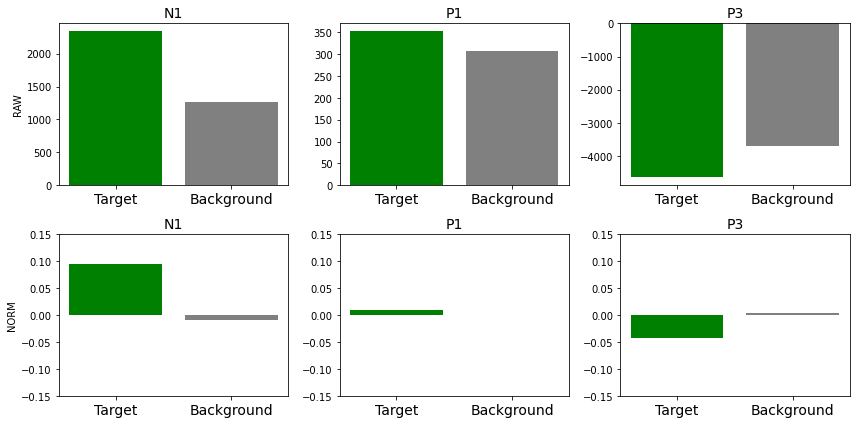

In [30]:
idxs_inside  = np.where(aeps_events[:, 1] == 2)[0]
idxs_outside = np.where(aeps_events[:, 1] == 1)[0]

fig, axes = plt.subplots(2, len(AEP_metrics_lims), figsize=(12, 6))
titles = ['RAW', 'NORM']

for j, metrics in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for i, data in enumerate(metrics.values()):
        d_inside  = data[idxs_inside].mean()
        d_outside = data[idxs_outside].mean()
        axes[j, i].bar([1, 2], [d_inside, d_outside], color=('green', 'grey'))
        axes[j, i].set_xticks([1, 2])  # set correct ticks and labels
        axes[j, i].set_xticklabels(['Target', 'Background'], fontsize=14)
        axes[j, i].set_title(list(AEP_metrics_lims.keys())[i], fontsize=14)

        if i == 0:
            axes[j, i].set_ylabel(titles[j])
            
        if j > 0:
            axes[j, i].set_ylim(-0.15, 0.15)
fig.tight_layout()

## Metric correlations - scatter

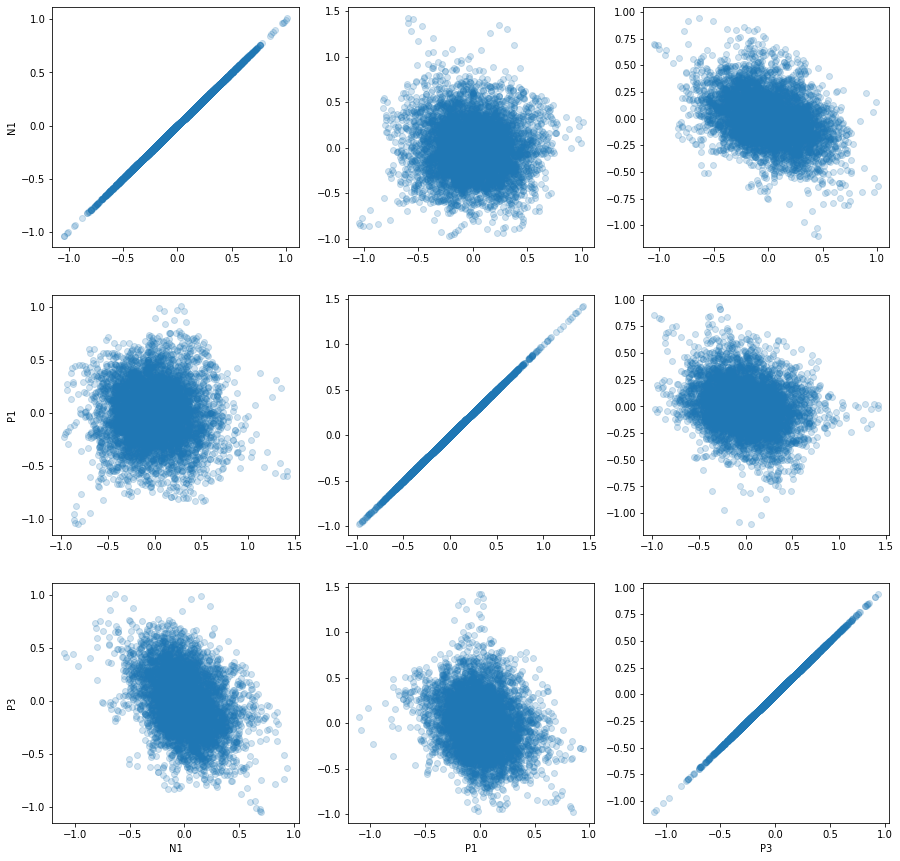

In [20]:
dim = len(AEP_metrics_raw)
fig, axes = plt.subplots(dim, dim, figsize=(15, 15))
for i, (m1_name, m1) in enumerate(AEP_metrics_norm.items()):
    for j, (m2_name, m2) in enumerate(AEP_metrics_norm.items()):
        axes[i, j].scatter(m1, m2, alpha=0.2)
        if j == 0:
            axes[i, j].set_ylabel(m1_name)
        if i == dim - 1:
            axes[i, j].set_xlabel(m2_name)

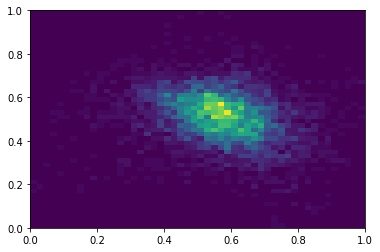

In [33]:
_ = plt.hist2d(AEP_metrics_norm['P1'], AEP_metrics_norm['P2'], bins=50)

## Instantaneous correlation between AEP metrics

In [21]:
session

'009266_hippoSIT_2023-04-24_16-56-55'

In [41]:
# get available units
unit_names = []
with h5py.File(h5name, 'r') as f:
    unit_names = [x for x in f['units']]
            
print(unit_names), len(unit_names)

['1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-19', '1-2', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1-26', '1-27', '1-28', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '3-10', '3-11', '3-12', '3-13', '3-14', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '4-10', '4-11', '4-12', '4-13', '4-14', '4-15', '4-16', '4-17', '4-2', '4-3', '4-4', '4-5', '4-6', '4-7', '4-8', '4-9', '5-10', '5-11', '5-12', '5-13', '5-14', '5-15', '5-16', '5-17', '5-18', '5-19', '5-2', '5-20', '5-21', '5-22', '5-23', '5-24', '5-25', '5-26', '5-27', '5-28', '5-29', '5-3', '5-30', '5-31', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '6-10', '6-11', '6-12', '6-13', '6-14', '6-15', '6-16', '6-17', '6-18', '6-19', '6-2', '6-20', '6-21', '6-3', '6-4', '6-5', '6-6', '6-7', '6-8', '6-9', '7-10', '7-11', '7-12', '7-13', '7-14', '7-15', '7-16', '7-17', '7-18', '7-19', '7-2', '7-20', '7-21', '7-3', '7-4', '7-5', '7-6', '7-7

(None, 150)

In [42]:
# read single units
single_units = {}
spike_times = {}

with h5py.File(h5name, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)

In [43]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

In [78]:
window_l = 40  # in AEP events, 10 sec is ~40 events
inst_corrs = np.zeros(len(AEP_metrics_norm['P1']) - window_l)
metric1, metric2 = AEP_metrics_norm['N1'], AEP_metrics_norm['P3']
#metric1, metric2 = AEP_metrics_raw['N1'], AEP_metrics_raw['P3']
#metric1, metric2 = i_rate[aeps_tl_idxs], N2_smooth_norm
for i in range(len(inst_corrs)):
    inst_corrs[i] = pearsonr(metric1[i:i + window_l], metric2[i:i + window_l])[0]

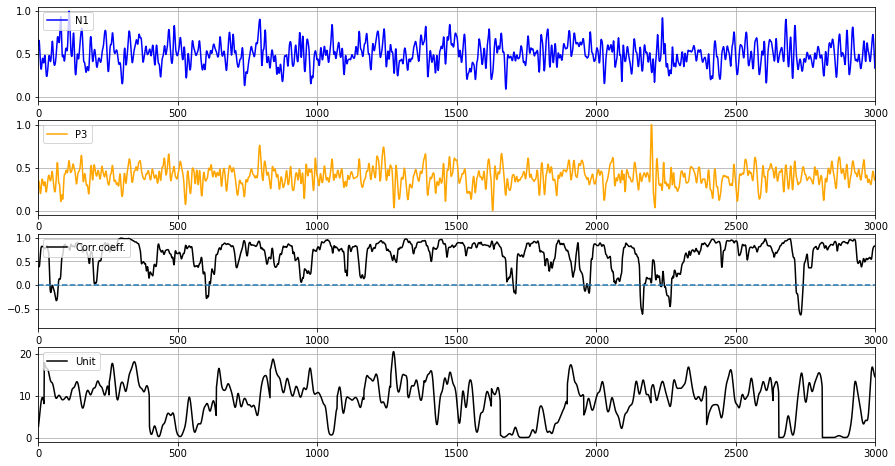

In [79]:
fig, axes = plt.subplots(4, 1, figsize=(15, 8))
axes[0].plot(metric1, color='blue', label='N1')
axes[1].plot(metric2, color='orange', label='P3')
axes[2].plot(inst_corrs, color='black', label='Corr.coeff.')
axes[2].axhline(0, ls='--')
axes[3].plot(single_units['8-8'][aeps_tl_idxs], color='black', label='Unit')
for ax in axes:
    ax.set_xlim(0, 3000)
    ax.grid()
    ax.legend(loc='upper left')
    #ax.axvline(530)
    #ax.axvline(580)

In [67]:
np.corrcoef(single_units['8-8'][aeps_tl_idxs][:-40], inst_corrs)

array([[1.        , 0.21074305],
       [0.21074305, 1.        ]])